In [1]:
pip install audiomentations

     ---------------------------------------- 77.0/77.0 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
%pip install tensorflow[and-cuda]

     ---------------------------------------- 99.0/99.0 MB 6.8 MB/s eta 0:00:00
  Using cached nvidia_curand_cu12-10.3.3.141-py3-none-win_amd64.whl (56.0 MB)
  Using cached nvidia_cublas_cu12-12.2.5.6-py3-none-win_amd64.whl (450.5 MB)
     ---------------------------------------- 18.6/18.6 MB 7.2 MB/s eta 0:00:00
     ---------------------------------------- 9.9/9.9 MB 7.8 MB/s eta 0:00:00
  Using cached tensorflow-2.16.1-cp310-cp310-win_amd64.whl (2.1 kB)
     -----------------------------------   357.6/376.9 MB 11.5 MB/s eta 0:00:02
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "e:\work\soundMap\.vevn\lib\site-packages\pip\_vendor\urllib3\response.py", line 435, in _error_catcher
    yield
  File "e:\work\soundMap\.vevn\lib\site-packages\pip\_vendor\urllib3\response.py", line 516, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "e:\work\soundMap\.vevn\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 94, in read
    self.__buf.write(data)
  File "C:\Users\Nikolas\AppData\Local\Programs\Python\Python310\lib\tempfile.py", line 483, in func_wrapper
    return func(*args, **kwargs)
OSError: [Errno 28] No space left on device

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "e:\work\soundMap\.vevn\lib\site-packages\pip\_internal\cli\base_command.py", line 167, in exc_logging_wrapper
    status = run_func(*args)
  File "e:\work\soundMap\.vevn\lib\site-packages\pip\_internal\cli\req_command.py", line 247, in

In [3]:
import os
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from module.sound import get_auduo_jump_power
import re

import importlib
#importlib.reload(module.sound)
# %load_ext autoreload
# %autoreload 2


C:\Users\Nikolas\AppData\Local\Temp\ipykernel_3740\1977282727.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Rename file in folder to format like 00011.wav

In [31]:
folder_path = 'raw_data'
folder_lim_path = 'raw_data_1s'
folder_name = 'pushka'
file_number = 0
pattern = r'^(\d+)\.wav$'
desired_sr=44100
# Rename file
for f in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, f)):
        folder_name = f
        file_number = 0
        file_count = 0
        file_number_min = 99999
        path = os.path.join(folder_path, folder_name)
        for filename in os.listdir(path):
            match = re.search(pattern, filename)
                
            if match: 
                n = int(match.group(1))
                if n< file_number_min:
                    file_number_min = n
                if n>file_number:
                    file_number = n
                # print(filename, file_number)
                #
                if filename!= f"{file_number:05}.wav":
                    if not os.path.isfile(os.path.join(path, f"{file_number:05}.wav")):
                        os.rename(os.path.join(path, filename), os.path.join(path,f"{file_number:05}.wav"));
        for filename in os.listdir(path):
            match = re.search(pattern, filename)
            new_file = f"{file_number:05}.wav"
            file_count=file_count+1
            if not match :
                file_number = file_number + 1
                os.rename(os.path.join(path, filename), os.path.join(path,f"{file_number:05}.wav"))

        print(f"file_count={file_count} file_number_min={file_number_min} folder_name={folder_name}")
        if(file_count<file_number_min):
            file_number=0
            for filename in os.listdir(path):
                file_number=file_number+1
                os.rename(os.path.join(path, filename), os.path.join(path,f"{file_number:05}.wav"));




file_count=20 file_number_min=1 folder_name=echo
file_count=94 file_number_min=1 folder_name=geran
file_count=123 file_number_min=1 folder_name=none
file_count=379 file_number_min=1 folder_name=pushka
file_count=18 file_number_min=1 folder_name=roked
file_count=9 file_number_min=1 folder_name=shots


In [7]:
def augmetion_audio_file_split(file_path, folder_lim_path, folder_name ,folder_lim_time, offset=1,  desired_sr=44100):
    # Создайте пустой DataFrame для хранения результатов

    folder  = os.path.join(folder_lim_path, folder_name)
    if not os.path.exists(folder):
        os.makedirs(folder)
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

    folder  = os.path.join(folder_path, folder_name)
    for filename in os.listdir(folder):
        if filename.endswith('.wav'): 
            file_path = os.path.join(folder_path, folder_name, filename)
            audio, sample_rate = librosa.load(file_path, sr=desired_sr)
            # Получение длины в секундах  
            audio_length = len(audio) / sample_rate
            folder_lim_time_sample = int(folder_lim_time*sample_rate)
            offset_sample = int(offset*folder_lim_time_sample)
            start_sample=0
            end_sample=folder_lim_time_sample
            sub_number =0
            while end_sample <= len(audio):
                sub_number = sub_number+1
                audio_split = audio[start_sample:end_sample]
                filename_new = filename[:-4] + f"_{sub_number:03}.wav"
                file_path_lim = os.path.join(folder_lim_path,folder_name, filename_new)
                sf.write(file_path_lim, audio_split, sample_rate, subtype='PCM_24')

                start_sample=start_sample+offset_sample
                end_sample=end_sample+offset_sample
                



def augmetion_audio_file_select(file_path, folder_lim_path, folder_name ,folder_lim_time, event_start=0.3, desired_sr=44100):
    
    # Specify the desired sampling rate (e.g., 44100 Hz)
    # desired_sr 

    # Создайте пустой DataFrame для хранения результатов
    file = []
    pick = []
    power = []

    # Путь к папке, содержащей ваши WAV-файлы
    data_csv = {'File':[], 'Pick':[], 'Power':[]}
    ##
    folder  = os.path.join(folder_lim_path, folder_name)
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

    folder  = os.path.join(folder_path, folder_name)
    for filename in os.listdir(folder):
        if filename.endswith('.wav'): 
            file_path = os.path.join(folder_path, folder_name, filename)
            audio, sample_rate = librosa.load(file_path, sr=desired_sr)
            # Получение длины в секундах  
            audio_length = len(audio) / sample_rate
            ( jump_x, jump_y  ) = get_auduo_jump_power(audio, sample_rate)
            if(len(jump_x)==0):
                print(filename, jump_x)
            else:
                data_csv['File'].append(filename)
                data_csv['Pick'].append(jump_x[0])
                data_csv ['Power'].append(jump_y[0])
                folder_lim_time_sample = int(folder_lim_time*sample_rate)
                if audio_length < 1:
                    padding = np.zeros(int(folder_lim_time_sample - len(audio)))
                    audio = np.concatenate(( padding, audio))
                else:
                    pik_time = jump_x[0]
                    pik_time_sample = int(pik_time*sample_rate)
                    start_time = pik_time_sample-int(folder_lim_time_sample*event_start)
                    pik_times=[start_time, start_time+folder_lim_time_sample]
                    if pik_times[0] < 0:
                        pik_times=[0, folder_lim_time_sample]
                    if pik_times[1] > len(audio):
                        pik_times=[len(audio-folder_lim_time_sample), len(audio)]

                    audio = audio[pik_times[0]:pik_times[1]]
                file_path_lim = os.path.join(folder_lim_path,folder_name, filename)
                sf.write(file_path_lim, audio, sample_rate, subtype='PCM_24')

    df = pd.DataFrame(data_csv) 

    # сохранение в Csv
    df.to_csv(os.path.join(folder_path, f'{folder_name}.xlsx'))


In [8]:
folder_path = 'raw_data'
folder_lim_path = 'raw_data_1s'
folder_name = 'pushka'
folder_lim_time = 1
augmetion_audio_file_select(folder_path, folder_lim_path, folder_name, folder_lim_time)

In [9]:
folder_path = 'raw_data'
folder_lim_path = 'raw_data_1s'
folder_lim_time = 1
augmetion_audio_file_split(folder_path, folder_lim_path, 'geran', folder_lim_time)
augmetion_audio_file_split(folder_path, folder_lim_path, 'none', folder_lim_time)
augmetion_audio_file_split(folder_path, folder_lim_path, 'roked', folder_lim_time)
augmetion_audio_file_split(folder_path, folder_lim_path, 'shots', folder_lim_time)


In [14]:

file_name = "02326.wav"
#file_path = os.path.join(folder_path,folder_name, file_name)
#ipd.Audio(file_path)
file_path = os.path.join(folder_lim_path,folder_name, file_name)
ipd.Audio(file_path)


In [16]:
audio, sample_rate = librosa.load(file_path, sr=desired_sr)


NameError: name 'desired_sr' is not defined

NameError: name 'audio' is not defined

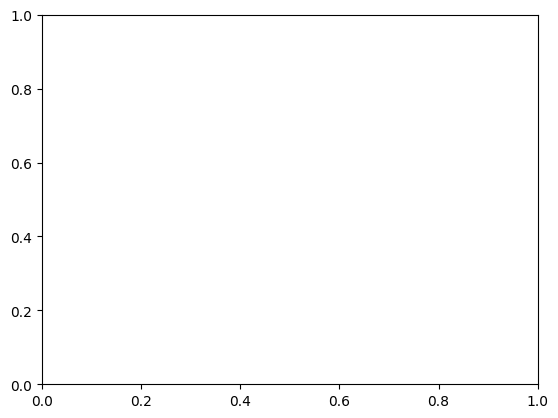

In [15]:

# Need show wave from audio array       

plt.subplots()
librosa.display.waveshow(audio, sr=sample_rate)
plt.title(file_name)


In [72]:
frameSize = 2048
hopSize = 512
stft_audio = librosa.stft(audio, n_fft = frameSize, hop_length = hopSize)
D_harmonic, D_percussive = librosa.decompose.hpss(stft_audio)

stft_audio_db = librosa.amplitude_to_db(np.abs(stft_audio), ref=np.max)
print(stft_audio.shape)

(1025, 87)


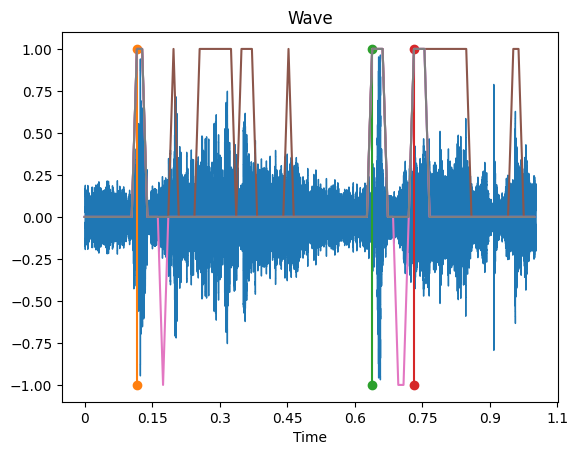

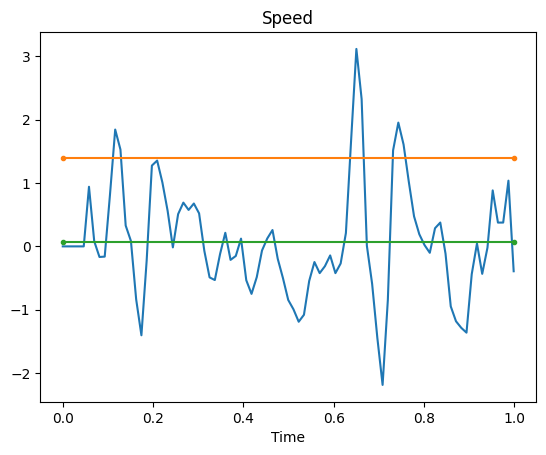

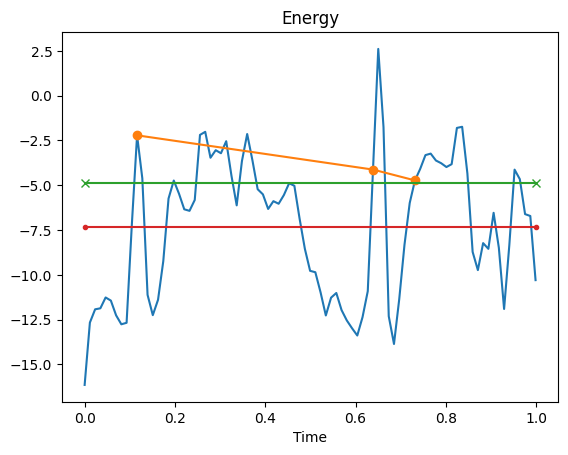

([0.11609977324263039, 0.6385487528344671, 0.7314285714285714],
 [-2.2139199, -4.125694, -4.729736])

In [75]:


get_auduo_jump_power(audio, sample_rate, show_chart=True)


(227.48734+28.657764j)


C:\Users\Nikolas\AppData\Local\Temp\ipykernel_19344\3658729663.py:12: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.display.specshow(librosa.power_to_db(stft_audio, ref=rp),sr=sample_rate, y_axis='log')
C:\Users\Nikolas\AppData\Local\Temp\ipykernel_19344\3658729663.py:17: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.display.specshow(librosa.power_to_db(D_harmonic, ref=rp), sr=sample_rate,y_axis='log')
C:\Users\Nikolas\AppData\Local\Temp\ipykernel_19344\3658729663.py:22: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.display.specshow(librosa.power_to_db(D_percussive, ref=rp),sr=sample_rate, y_axis='log', x_axis='time')


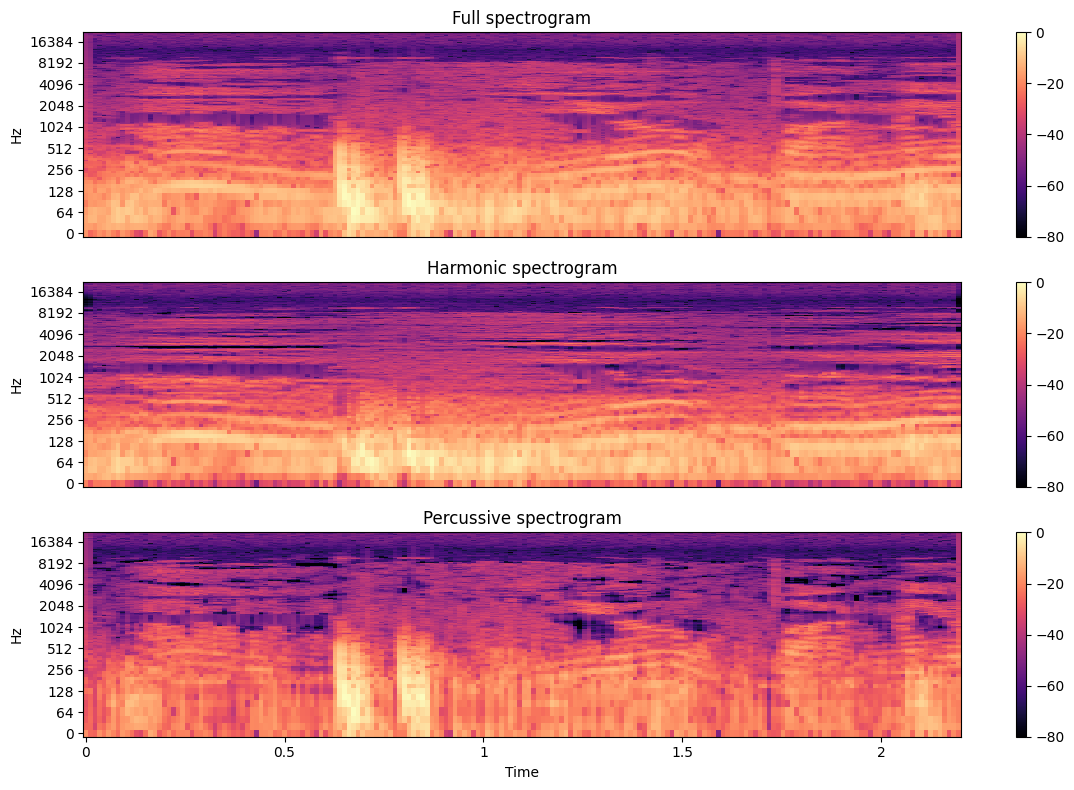

In [ ]:
stft_audio = librosa.stft(audio)#, n_fft = frameSize, hop_length = hopSize)
D_harmonic, D_percussive = librosa.decompose.hpss(stft_audio)

#rp = np.max(np.abs(stft_audio))
rp = np.max(stft_audio )
print(rp)
rp = np.max

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.power_to_db(stft_audio, ref=rp),sr=sample_rate, y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.power_to_db(D_harmonic, ref=rp), sr=sample_rate,y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.power_to_db(D_percussive, ref=rp),sr=sample_rate, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

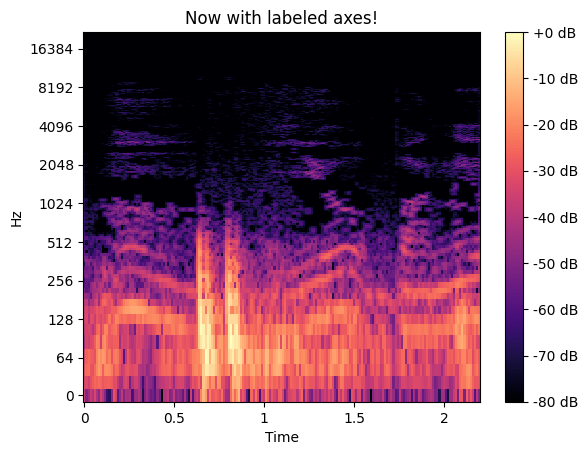

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(stft_audio_db,sr=sample_rate, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Now with labeled axes!')
fig.colorbar(img, ax=ax, format="%+2.f dB")


In [2]:
fig, ax = plt.subplots()
M = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
M_db = librosa.power_to_db(M, ref=np.max)
M_db = librosa.amplitude_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel',sr=sample_rate, x_axis='time',y_axis='log' , ax=ax)
ax.set(title='Mel spectrogram display')
fig.colorbar(img, ax=ax, format="%+2.f dB")

NameError: name 'plt' is not defined